In [1]:
import os
import sys
# Repository source: https://github.com/qubvel/efficientnet
sys.path.append(os.path.abspath('../input/efficientnet/efficientnet-master/efficientnet-master/'))
from efficientnet import EfficientNetB5

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
import pandas as pd
import numpy as np
import os

import cv2

from skimage.io import imread, imshow
from skimage.transform import resize

from PIL import Image

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger)
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Standard dependencies
import time
import scipy as sp
from tqdm import tqdm
from functools import partial

# Machine Learning
import tensorflow as tf
import keras
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.activations import relu, elu, hard_sigmoid
from keras.optimizers import Adam
from keras.models import Sequential
from keras.engine import Layer, InputSpec
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score

# Path specifications
KAGGLE_DIR = '../input/aptos2019-blindness-detection/'
TRAIN_DF_PATH = KAGGLE_DIR + "train.csv"
TEST_DF_PATH = KAGGLE_DIR + 'test.csv'
TRAIN_IMG_PATH = KAGGLE_DIR + "train_images/"
TEST_IMG_PATH = KAGGLE_DIR + 'test_images/'

# Specify title of our final model
SAVED_MODEL_NAME = 'effnet_modelB5-C.h5'

# Set seed for reproducability
seed = 1234
np.random.seed(seed)
tf.set_random_seed(seed)

# For keeping time. GPU limit for this competition is set to ± 9 hours.
t_start = time.time()

# File sizes and specifications
print('\n# Files and file sizes')
for file in os.listdir(KAGGLE_DIR):
    print('{}| {} MB'.format(file.ljust(30), 
                             str(round(os.path.getsize(KAGGLE_DIR + file) / 1000000, 2))))


# Files and file sizes
train.csv                     | 0.05 MB
sample_submission.csv         | 0.03 MB
test.csv                      | 0.03 MB
train_images                  | 0.14 MB
test_images                   | 0.07 MB


In [4]:
os.listdir('../input')

['efficientnet-keras-weights-b0b5',
 'aptos2019-blindness-detection',
 'diabetic-retinopathy-resized-train-15-19-dg',
 'efficientnet',
 'aptos-00']

In [5]:
# Path specifications
TRAIN_DF_A_PATH = "../input/aptos-00/df_train_A.csv"
TRAIN_DF_B_PATH = "../input/aptos-00/df_train_B.csv"
TRAIN_DF_C_PATH = "../input/aptos-00/df_train_C.csv"
TRAIN_DF_D_PATH = "../input/aptos-00/df_train_D.csv"


print("Image IDs and Labels (TRAIN-A)")
train_df_A = pd.read_csv(TRAIN_DF_A_PATH)
print(f"Training images: {train_df_A.shape[0]}")
display(train_df_A.head())

print("Image IDs and Labels (TRAIN-B)")
train_df_B = pd.read_csv(TRAIN_DF_B_PATH)
print(f"Training images: {train_df_B.shape[0]}")
display(train_df_B.head())

print("Image IDs and Labels (TRAIN-C)")
train_df_C = pd.read_csv(TRAIN_DF_C_PATH)
print(f"Training images: {train_df_C.shape[0]}")
display(train_df_C.head())

print("Image IDs and Labels (TRAIN-D)")
train_df_D = pd.read_csv(TRAIN_DF_D_PATH)
print(f"Training images: {train_df_D.shape[0]}")
display(train_df_D.head())

Image IDs and Labels (TRAIN-A)
Training images: 3662


,id_code,diagnosis,file_name,binary_target
0,000c1434d8d7,2,000c1434d8d7.png,1
1,001639a390f0,4,001639a390f0.png,1
2,0024cdab0c1e,1,0024cdab0c1e.png,1
3,002c21358ce6,0,002c21358ce6.png,0
4,005b95c28852,0,005b95c28852.png,0


Image IDs and Labels (TRAIN-B)
Training images: 1857


,id_code,diagnosis,file_name,binary_target
0,000c1434d8d7,2,000c1434d8d7.png,1
1,001639a390f0,4,001639a390f0.png,1
2,0024cdab0c1e,1,0024cdab0c1e.png,0
3,0083ee8054ee,4,0083ee8054ee.png,1
4,00a8624548a9,2,00a8624548a9.png,1


Image IDs and Labels (TRAIN-C)
Training images: 1487


,id_code,diagnosis,file_name,binary_target
0,000c1434d8d7,2,000c1434d8d7.png,0
1,001639a390f0,4,001639a390f0.png,1
2,0083ee8054ee,4,0083ee8054ee.png,1
3,00a8624548a9,2,00a8624548a9.png,0
4,00b74780d31d,2,00b74780d31d.png,0


Image IDs and Labels (TRAIN-D)
Training images: 488


,id_code,diagnosis,file_name,binary_target
0,001639a390f0,4,001639a390f0.png,1
1,0083ee8054ee,4,0083ee8054ee.png,1
2,0104b032c141,3,0104b032c141.png,0
3,0243404e8a00,4,0243404e8a00.png,1
4,02685f13cefd,4,02685f13cefd.png,1


In [6]:
df = train_df_B
df0 = df.iloc[:0,:]
df1 = df.iloc[:0,:]

In [7]:
os.listdir('../input/diabetic-retinopathy-resized-train-15-19-dg/resized_train_15_19_dg/trainlabels')

['trainLabels15.csv',
 'trainLabels19.csv',
 'DGTraining.csv',
 'testLabels15.csv',
 'DGTesting.csv']

In [8]:
df_x15 = pd.read_csv('../input/diabetic-retinopathy-resized-train-15-19-dg/resized_train_15_19_dg/trainlabels/trainLabels15.csv')
df_x19 = pd.read_csv('../input/diabetic-retinopathy-resized-train-15-19-dg/resized_train_15_19_dg/trainlabels/trainLabels19.csv')

In [9]:
df_x19['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [10]:
df_x15['level'].value_counts()

0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64

In [11]:
df_x15 = df_x15.rename(columns={"image": "id_code", "level": "diagnosis"})

In [12]:
df_1_x15 = df_x15[df_x15['diagnosis'] == 1]
df_2_x15 = df_x15[df_x15['diagnosis'] == 2]
df_3_x15 = df_x15[df_x15['diagnosis'] == 3]
df_4_x15 = df_x15[df_x15['diagnosis'] == 4]

df_1_x19 = df_x19[df_x19['diagnosis'] == 1]
df_2_x19 = df_x19[df_x19['diagnosis'] == 2]
df_3_x19 = df_x19[df_x19['diagnosis'] == 3]
df_4_x19 = df_x19[df_x19['diagnosis'] == 4]

In [13]:
df_1_x15['binary_target'] = 0
df_2_x15['binary_target'] = 1
df_3_x15['binary_target'] = 1
df_4_x15['binary_target'] = 1

df_1_x19['binary_target'] = 0
df_2_x19['binary_target'] = 1
df_3_x19['binary_target'] = 1
df_4_x19['binary_target'] = 1

In [14]:
df = pd.concat([df_1_x15, df_2_x15,df_3_x15, df_4_x15, df_1_x19, df_2_x19, df_3_x19, df_4_x19], axis=0)

In [15]:
# Add a file_name column to df_train and df_test

def create_fname(x):
    
    fname = str(x) + '.jpg'
    
    return fname

df['file_name'] = df['id_code'].apply(create_fname)

In [16]:
# Check the target distribution

df['binary_target'].value_counts()

1    8360
0    2813
Name: binary_target, dtype: int64

In [17]:
df_0 = df[df['binary_target'] == 0]
df_1 = df[df['binary_target'] == 1]


df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)

print(df_data.shape)

df_data.head()

(11173, 4)


,id_code,diagnosis,binary_target,file_name
2691,a5a2a7003d60,1,0,a5a2a7003d60.jpg
3967,9384_left,2,1,9384_left.jpg
7628,40049_right,2,1,40049_right.jpg
9365,24163_left,4,1,24163_left.jpg
5913,25401_left,2,1,25401_left.jpg


In [18]:
# Check the new target distribution

df_data['binary_target'].value_counts()

1    8360
0    2813
Name: binary_target, dtype: int64

In [19]:
df_train, df_val = train_test_split(df_data, test_size=0.1, random_state=11)

print(df_train.shape)
print(df_val.shape)

(10055, 4)
(1118, 4)


In [20]:
# check the train set target distribution
df_train['binary_target'].value_counts()

1    7526
0    2529
Name: binary_target, dtype: int64

In [21]:
# check the train set target distribution
df_val['binary_target'].value_counts()

1    834
0    284
Name: binary_target, dtype: int64

In [22]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create sub folders inside 'base_dir':

# train_dir
    # a_0
    # b_1

# val_dir
    # a_0
    # b_1


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
a_0 = os.path.join(train_dir, 'a_0')
os.mkdir(a_0)
b_1 = os.path.join(train_dir, 'b_1')
os.mkdir(b_1)


# create new folders inside val_dir
a_0 = os.path.join(val_dir, 'a_0')
os.mkdir(a_0)
b_1 = os.path.join(val_dir, 'b_1')
os.mkdir(b_1)

In [23]:
# Check that the folders exist
os.listdir('base_dir')

['train_dir', 'val_dir']

In [24]:
df_train.head()

,id_code,diagnosis,binary_target,file_name
4004,9717_right,2,1,9717_right.jpg
8443,17899_left,3,1,17899_left.jpg
4913,16963_left,2,1,16963_left.jpg
9039,3993_right,4,1,3993_right.jpg
1098,19158_left,1,0,19158_left.jpg


In [25]:
# Set the file_name as the index in df_data
df_data.set_index('file_name', inplace=True)

In [26]:
# Specify image size
IMG_WIDTH = 456
IMG_HEIGHT = 456
CHANNELS = 3

In [27]:
os.listdir('../input/aptos2019-blindness-detection')

['train.csv',
 'sample_submission.csv',
 'test.csv',
 'train_images',
 'test_images']

In [28]:
IMG_WIDTH = 456
IMG_HEIGHT = 456
CHANNELS = 3

# Get a list of train and val images
train_list = list(df_train['file_name'])

# ============================
# Transfer the train images
# ============================

for fname in train_list:
    
    label = df_data.loc[fname,'binary_target']
    
    if label == 0:
        sub_folder = 'a_0'
        # source path to image
        src = os.path.join('../input/diabetic-retinopathy-resized-train-15-19-dg/resized_train_15_19_dg/resized_train_15_19_DG', fname)
        # destination path to image
        dst = os.path.join(train_dir, sub_folder, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (456, 456))
        cv2.imwrite(dst, image)
        # save the image at the destination
        # save the image using PIL
        #result = Image.fromarray(image.astype(np.uint8))
        #result.save(dst)
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)
        
        
    if label == 1:
        sub_folder = 'b_1'
        # source path to image
        src = os.path.join('../input/diabetic-retinopathy-resized-train-15-19-dg/resized_train_15_19_dg/resized_train_15_19_DG', fname)
        # destination path to image
        dst = os.path.join(train_dir, sub_folder, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (456, 456))
        cv2.imwrite(dst, image)
        
        
# ============================
# Transfer the val images
# ============================

# Get a list of train and val images
val_list = list(df_val['file_name'])

for fname in val_list:
    
    label = df_data.loc[fname,'binary_target']
    
    if label == 0:
        sub_folder = 'a_0'
        # source path to image
        src = os.path.join('../input/diabetic-retinopathy-resized-train-15-19-dg/resized_train_15_19_dg/resized_train_15_19_DG', fname)
        # destination path to image
        dst = os.path.join(val_dir, sub_folder, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (456, 456))
        cv2.imwrite(dst, image)
        
        
    if label == 1:
        sub_folder = 'b_1'
        # source path to image
        src = os.path.join('../input/diabetic-retinopathy-resized-train-15-19-dg/resized_train_15_19_dg/resized_train_15_19_DG', fname)
        # destination path to image
        dst = os.path.join(val_dir, sub_folder, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (456, 456))
        cv2.imwrite(dst, image)

In [29]:
# Check how many images are in the train sub folders

print(len(os.listdir('base_dir/train_dir/a_0')))
print(len(os.listdir('base_dir/train_dir/b_1')))

2529
7526


In [30]:
# Check how many images are in the val sub folders

print(len(os.listdir('base_dir/val_dir/a_0')))
print(len(os.listdir('base_dir/val_dir/b_1')))

284
834


### Setup Generators

In [31]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (456, 456))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

In [32]:
IMG_WIDTH = 456
IMG_HEIGHT = 456
CHANNELS = 3

In [33]:
train_path = 'base_dir/train_dir'
val_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 8
val_batch_size = 8

# Get the number of train and val steps
train_steps = np.ceil(num_train_samples // train_batch_size)
val_steps = np.ceil(num_val_samples // val_batch_size)
# Pre-process the input images in the same way as the ImageNet images 
datagen = ImageDataGenerator(
    preprocessing_function= preprocess_image,
    rescale=1 / 255)

train_gen = datagen.flow_from_directory(train_path,
                                            target_size=(456,456),
                                            batch_size=train_batch_size)

val_gen = datagen.flow_from_directory(val_path,
                                            target_size=(456,456),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
# We are only going to use this to make a prediction on the val set. That's
# why the path is set as val_path
test_gen = datagen.flow_from_directory(val_path,
                                            target_size=(456,456),
                                            batch_size=val_batch_size,
                                            shuffle=False)

Found 10055 images belonging to 2 classes.
Found 1118 images belonging to 2 classes.
Found 1118 images belonging to 2 classes.


In [34]:
class GroupNormalization(Layer):
    """Group normalization layer
    Group Normalization divides the channels into groups and computes within each group
    the mean and variance for normalization. GN's computation is independent of batch sizes,
    and its accuracy is stable in a wide range of batch sizes
    # Arguments
        groups: Integer, the number of groups for Group Normalization.
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `BatchNormalization`.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # References
        - [Group Normalization](https://arxiv.org/abs/1803.08494)
    """

    def __init__(self,
                 groups=4,
                 axis=-1,
                 epsilon=1e-5,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(GroupNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]

        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')

        if dim < self.groups:
            raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
                             'more than the number of channels (' +
                             str(dim) + ').')

        if dim % self.groups != 0:
            raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
                             'multiple of the number of channels (' +
                             str(dim) + ').')

        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, **kwargs):
        input_shape = K.int_shape(inputs)
        tensor_input_shape = K.shape(inputs)

        # Prepare broadcasting shape.
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(1, self.groups)

        reshape_group_shape = K.shape(inputs)
        group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
        group_axes[self.axis] = input_shape[self.axis] // self.groups
        group_axes.insert(1, self.groups)

        # reshape inputs to new group shape
        group_shape = [group_axes[0], self.groups] + group_axes[2:]
        group_shape = K.stack(group_shape)
        inputs = K.reshape(inputs, group_shape)

        group_reduction_axes = list(range(len(group_axes)))
        group_reduction_axes = group_reduction_axes[2:]

        mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
        variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

        inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

        # prepare broadcast shape
        inputs = K.reshape(inputs, group_shape)
        outputs = inputs

        # In this case we must explicitly broadcast all parameters.
        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            outputs = outputs * broadcast_gamma

        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            outputs = outputs + broadcast_beta

        outputs = K.reshape(outputs, tensor_input_shape)

        return outputs

    def get_config(self):
        config = {
            'groups': self.groups,
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(GroupNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [35]:
# Load in EfficientNetB5
effnet = EfficientNetB5(weights=None,
                        include_top=False,
                        input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))
effnet.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5')

In [36]:
# Replace all Batch Normalization layers by Group Normalization layers
for i, layer in enumerate(effnet.layers):
    if "batch_normalization" in layer.name:
        effnet.layers[i] = GroupNormalization(groups=4, axis=-1, epsilon=0.00001)

In [37]:
def build_model():
    """
    A custom implementation of EfficientNetB5
    for the APTOS 2019 competition
    
    """
    model = Sequential()
    model.add(effnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.1))
    #model.add(Dense(5, activation=sigmoid))
    model.add(Dense(2, activation="hard_sigmoid"))

    print(model.summary())
    return model

# Initialize model
model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 15, 15, 2048)      28168048  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 28,172,146
Trainable params: 28,172,146
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'a_0': 0, 'b_1': 1}


In [39]:
class_weights={
    0: 1.0, # Class 0
    1: 1.0, # Class 1
}

In [40]:
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy])


filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')


reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.0000001)

early_stopper = EarlyStopping(monitor="val_categorical_accuracy", 
                      mode="max", 
                      patience=12)

csv_logger = CSVLogger(filename='training_log.csv',
                       separator=',',
                       append=False)
                              
                              
callbacks_list = [checkpoint, reduce_lr, early_stopper, csv_logger]

history = model.fit_generator(train_gen, steps_per_epoch=train_gen.samples // train_batch_size, 
                              class_weight=class_weights,
                    validation_data=val_gen,
                    validation_steps=val_gen.samples // val_batch_size,
                    epochs=17, verbose=1,
                   callbacks=[reduce_lr, early_stopper, csv_logger])

Epoch 1/17
1256/1256 [==============================] - 1255s 999ms/step - loss: 0.5648 - categorical_accuracy: 0.7370 - val_loss: 0.5227 - val_categorical_accuracy: 0.7500
Epoch 2/17
1256/1256 [==============================] - 1221s 972ms/step - loss: 0.5054 - categorical_accuracy: 0.7547 - val_loss: 0.4986 - val_categorical_accuracy: 0.7568
Epoch 3/17
1256/1256 [==============================] - 1226s 976ms/step - loss: 0.4893 - categorical_accuracy: 0.7700 - val_loss: 0.5225 - val_categorical_accuracy: 0.7640
Epoch 4/17
1256/1256 [==============================] - 1223s 974ms/step - loss: 0.4841 - categorical_accuracy: 0.7767 - val_loss: 0.4970 - val_categorical_accuracy: 0.7703
Epoch 5/17
 317/1256 [======>.......................] - ETA: 14:43 - loss: 0.4432 - categorical_accuracy: 0.7874

In [41]:
# Save the weights
model.save_weights('model.h5')

In [42]:
# load the training log
df = pd.read_csv('training_log.csv')

# we are monitoring val_loss
best_acc = df['val_categorical_accuracy'].max()

# display the row with the best accuracy
df[df['val_categorical_accuracy'] == best_acc]

,epoch,categorical_accuracy,loss,lr,val_categorical_accuracy,val_loss
15,15,0.830397,0.371946,0.000005,0.802703,0.588299


In [43]:
# Here the best epoch will be used.
model.load_weights('model.h5')

val_loss, val_categorical_accuracy = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_categorical_accuracy:', val_categorical_accuracy)

val_loss: 0.5796791804593562
val_categorical_accuracy: 0.7966405375139978


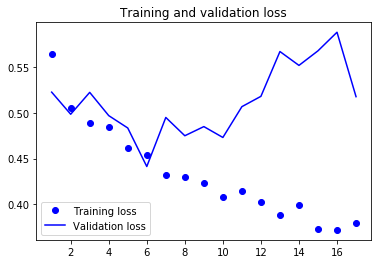

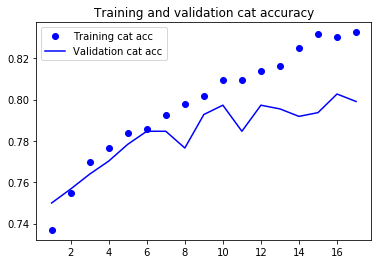

<Figure size 432x288 with 0 Axes>

In [44]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()



plt.show()

In [45]:
# Delete the image data directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

shutil.rmtree('base_dir')